In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import torch
import numpy

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from rlplay.engine import collect  # the collector's core

In [5]:
from rlplay.engine import BaseActorModule

In [6]:
from rlplay.utils.common import multinomial

class nonRecurrentPolicyWrapper(BaseActorModule):
    """Example wrapper for a non-recurrent policy.
    
    Details
    -------
    This example assumes flat `Discrete(n)` action space, and
    simple non-structured observation space, e.g. a python scalar
    or a `numpy.array`.
    """

    def __init__(self, policy, *, epsilon=0.1):
        super().__init__()
        self.policy, self.epsilon = policy, epsilon

    def forward(self, obs, act=None, rew=None, fin=None, *, hx=None):
        # Everything is  [T x B x ...]
        logits, hx = self.policy(obs, act, rew), ()

        # value must not have any trailing dims, i.e. T x B
        value = logits.new_zeros(fin.shape)

        # XXX eps-greedy?
        if self.training:
            unif = torch.tensor(1. / logits.shape[-1])

            prob = logits.detach().exp()
            prob.mul_(1 - self.epsilon)
            prob.add_(unif, alpha=self.epsilon)

            actions = multinomial(prob)

        else:
            actions = logits.argmax(dim=-1)

        return actions, hx, dict(value=value, logits=logits)

<br>

### nle factory 

In [8]:
from pyhocon import ConfigFactory

config = ConfigFactory.parse_file('../experiments/conf/nle_draft.hocon')
config

ConfigTree([('env',
             ConfigTree([('env_type', 'nle'),
                         ('video_path', 'artifacts/video/'),
                         ('goal_achieving_criterion', 'position'),
                         ('goal_type', 'from_current_episode'),
                         ('from_buffer_choice_params',
                          ConfigTree([('buffer_size', 100000),
                                      ('warmup_steps', 10)]))])),
            ('seed', 42),
            ('outputs',
             ConfigTree([('save_example', True),
                         ('path', 'artifacts/models/minigrid_worker.p')]))])

In [13]:
import sys
sys.path.append('../experiments')

from train_worker import gen_navigation_env

def factory():
    return gen_navigation_env(config['env'])

<br>

### Rollout collection (multi-process)

In [7]:
from rlplay.engine.rollout import multi

In [8]:
from rlplay.engine import evaluate

In [9]:
def test(
    factory, actor, n_envs=4,
    *, n_steps=None, close=True, render=False, device=None
):
    # spawn a batch of environments
    envs = [factory() for _ in range(n_envs)]

    try:
        while True:
            rewards, bootstrap = evaluate(
                envs, actor, n_steps=n_steps,
                render=render, device=device)

            # get the accumulated rewards (gamma=1)
            yield sum(rewards)

    finally:
        if close:
            for e in envs:
                e.close()
    

<br>

In [20]:
T, B = 21, 4

# generator of rollout batches
batchit = multi.rollout(
    factory,
    learner,
    n_steps=T,
    n_actors=4,
    n_per_actor=B,
    n_buffers=4,
    n_per_batch=2,
    sticky=sticky,  # so that we can leverage cudnn's fast RNN implementations
    pinned=False,
    close=False,
    device=device_,
    start_method='fork',  # fork in notebook for macos, spawn in linux
)

Implement your favourite training method

In [21]:
import tqdm
from torch.nn.utils import clip_grad_norm_

gamma = 0.99
losses, rewards = [], []

# generator of evaluation rewards
test_it = test(factory, learner, n_envs=4, n_steps=500, device=device_)

# the training loop
exclude = {'returns'}
ewm, alpha = None, 0.5
for epoch in tqdm.tqdm(range(400)):
    for j, batch in zip(range(100), batchit):

        optim.zero_grad()
        loss, info = a2c(batch, learner, gamma=gamma, c_rho=1.5)
        loss.backward()
        grad_norm = clip_grad_norm_(learner.parameters(), max_norm=1e2)
        optim.step()

        losses.append({
            k: float(v) for k, v in info.items() if k not in exclude
        })
        losses[-1].update({'grad': float(grad_norm)})

    rewards.append(next(test_it))
    
    # track minimal reward
    if ewm is None:
        ewm = rewards[-1].min()
    else:
        ewm += alpha * (rewards[-1].min() - ewm)

    if ewm > 498:
        break

# close the generators
batchit.close()
test_it.close()

 22%|██▏       | 86/400 [02:18<08:26,  1.61s/it]


<br>

In [22]:
def collate(records):
    """collate identically keyed dicts"""
    out, n_records = {}, 0
    for record in records:
        for k, v in record.items():
            out.setdefault(k, []).append(v)
    
    return out

In [23]:
data = {k: numpy.array(v) for k, v in collate(losses).items()}

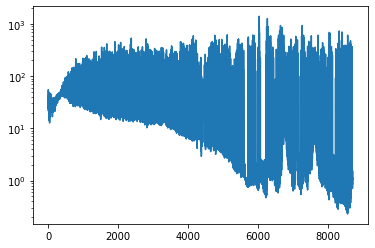

In [24]:
if 'value_loss' in data:
    plt.semilogy(data['value_loss'])

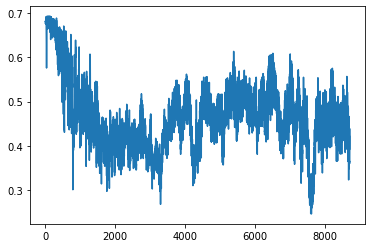

In [25]:
plt.plot(data['entropy'])

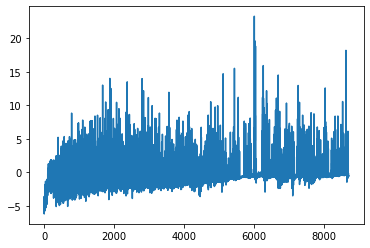

In [26]:
plt.plot(data['policy_score'])

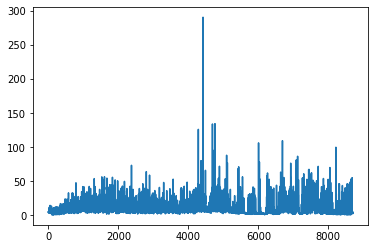

In [27]:
plt.plot(data['grad'])

In [28]:
rewards = numpy.stack(rewards, axis=0)

In [29]:
rewards

array([[ 13.,  25.,  11.,  29.],
       [ 20.,  62.,  24.,  18.],
       [ 22.,  24.,  14.,  27.],
       [ 16.,  19.,  24.,  21.],
       [105.,  67., 145.,  21.],
       [132.,  45., 111., 110.],
       [ 98.,  45., 113.,  85.],
       [134., 225., 126., 119.],
       [ 34.,  34., 154.,  38.],
       [235., 213., 161., 182.],
       [101., 108., 110., 130.],
       [108., 102., 104., 104.],
       [113., 126., 115., 171.],
       [ 18., 116., 125., 107.],
       [151., 133., 133., 159.],
       [ 30.,  19.,  33.,  12.],
       [ 99.,  20., 103., 105.],
       [110., 114., 130., 125.],
       [120.,  33.,  15.,  95.],
       [134., 127., 131., 119.],
       [118., 115.,  25., 118.],
       [181., 212., 174., 207.],
       [192., 222.,  79., 171.],
       [154., 139., 118., 130.],
       [107., 124., 107., 117.],
       [107.,  28., 108., 104.],
       [180., 143., 111., 126.],
       [152., 125., 129., 127.],
       [149., 119., 146., 138.],
       [262., 234., 234., 217.],
       [14

In [30]:
m, s = numpy.median(rewards, axis=-1), rewards.std(axis=-1)

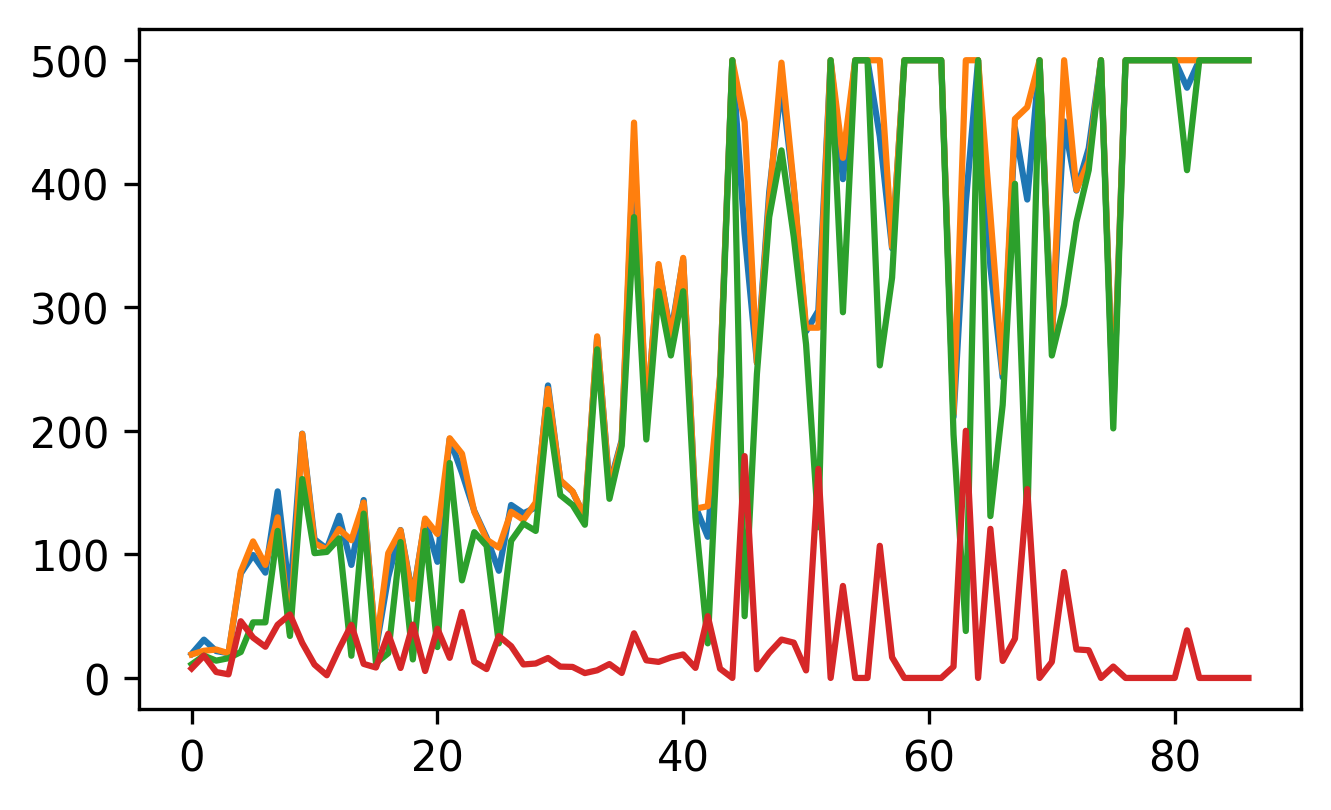

In [31]:
fi, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=300)

ax.plot(numpy.mean(rewards, axis=-1))
ax.plot(numpy.median(rewards, axis=-1))
ax.plot(numpy.min(rewards, axis=-1))
ax.plot(numpy.std(rewards, axis=-1))
# ax.plot(m+s * 1.96)
# ax.plot(m-s * 1.96)

plt.show()

In [32]:
with factory() as env:
    learner.eval()
    rewards, bootstrap = evaluate([
        env
    ], learner, render=True, n_steps=1e4, device=device_)

print(sum(rewards), bootstrap[0])

[4168.] 87.00935


<br>

In [33]:
assert False

AssertionError: 

<br>

In [ ]:
import matplotlib.pyplot as plt

p_l, v_l, ent = zip(*losses)

plt.plot(p_l)
plt.plot(ent)

In [ ]:
plt.plot(v_l)

Run in the environment

In [ ]:
plt.plot([
    sum(evaluate(factory, learner, render=False))
    for _ in range(200)
])

<br>

In [ ]:
assert False

In [ ]:
class Bar:
    def __init__(self, parent):
        self.parent = parent
        self._range = range(self.parent.n)
        self._it = iter(self._range)

    def __iter__(self):
        return self

    def __next__(self):
        return next(self._it)

class Foo:
    def __init__(self, n=10):
        self.n = n

    def __iter__(self):
        return Bar(self)


In [ ]:
list(Foo())

In [ ]:
class Bar:
    def __init__(self, parent):
        self.parent = parent

    def __iter__(self):
        yield from range(self.parent.n)

class Foo:
    def __init__(self, n=10):
        self.n = n

    def __iter__(self):
        return iter(Bar(self))


<br>